In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sympy as smp
from scipy.fft import fftfreq, fft, ifft, fft2, ifft2
plt.style.use("default")
from sympy.integrals.transforms import _fourier_transform
smp.init_printing()
from scipy.integrate import quad, quad_vec
from scipy.stats import norminvgauss
from numpy import exp, pi, sqrt, log

from sympy import DiracDelta, Heaviside, conjugate, gamma, digamma, beta
from sympy import besselj, besseli, besselk
# bessel func of first kind, modified bessel of first kind, mod second kind

# Fourier Transform

This occurs when the functional form of your time series is known analytically (i.e. you have a formula $f(x)=...$ for it) and goes from $-\infty$ to $\infty$

$$\hat{f}(\xi) = \int_{-\infty}^{\infty} f(x) e^{i \xi x} dx $$
**Solving Analytically (If Possible)**: Be careful giving proper information about your variables when you define them for sympy to work properly!

In [26]:
x, xi = smp.symbols('x, xi', real=True)
lam = smp.symbols('lambda', real=True, positive=True)
f = smp.exp(-lam*abs(x))
f

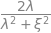

In [29]:
# Correct example from the notes.
x_FT = _fourier_transform(f, x, xi, 1, 1, "lap")
x_FT

**Solving Numerically**: Sometimes sympy can't evaluate integrals analytically, in which case you'll need to use scipy.

Typically this means the cell will run endlessly, or throw an exception.

## Scipy Numerical Fourier Transform

In [141]:
# We need to integrate the real and complex parts independently given scipy cannot recognise them individually.

def f(x, lam):
    #return np.exp(-lam * x**2) * np.sin(lam*x) * x**4
    return np.exp(-lam*abs(x))

def get_f_FT(f, xi, lam):
    f_FT_integrand_real = lambda x: np.real(f(x, lam)*np.exp(1j*xi*x))
    f_FT_integrand_comp = lambda x: np.imag(f(x, lam)*np.exp(1j*xi*x))
    f_FT_real = quad(f_FT_integrand_real, -np.inf, np.inf)[0]
    f_FT_comp = quad(f_FT_integrand_comp, -np.inf, np.inf)[0]
    return f_FT_real + 1j*f_FT_comp

In [142]:
xi = np.linspace(-4, 4, 100)
x_FT = np.vectorize(get_f_FT)(f, xi, lam=2)

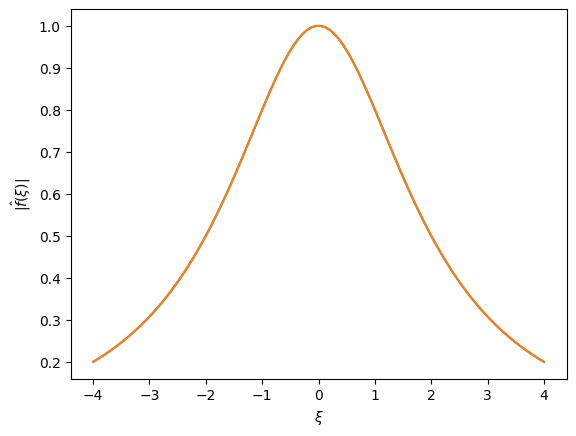

In [143]:
def cauchy(xi, lam): return 2*lam/(lam**2 + xi**2)
plt.plot(xi, np.abs(x_FT))
plt.plot(xi, cauchy(xi, lam=2))
plt.ylabel('$|\hat{f}(\\xi)|$')
plt.xlabel('$\\xi$')
plt.show()
# Two functions perfectly overlap.

## Scipy Numerical INVERSE Fourier Transform

In [64]:
# We need to integrate the real and complex parts independently given scipy cannot recognise them individually.

def get_f_InvFT(f, x, lam):
    f_FT_integrand_real = lambda xi: 1/(2*np.pi)*np.real(f(xi, lam)*np.exp(-1j*xi*x))
    f_FT_integrand_comp = lambda xi: 1/(2*np.pi)*np.imag(f(xi, lam)*np.exp(-1j*xi*x))
    f_FT_real = quad(f_FT_integrand_real, -np.inf, np.inf)[0]
    f_FT_comp = quad(f_FT_integrand_comp, -np.inf, np.inf)[0]
    return f_FT_real + 1j*f_FT_comp

In [65]:
def cauchy(xi, lam): return 2*lam/(lam**2 + xi**2)

x = np.linspace(-4, 4, 100)
x_InvFT = np.vectorize(get_f_InvFT)(cauchy, x, lam=2)

/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykernel_31556/1629601486.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  f_FT_real = quad(f_FT_integrand_real, -np.inf, np.inf)[0]
/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykernel_31556/1629601486.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  f_FT_real = quad(f_FT_integrand_real, -np.inf, np.inf)[0]


/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


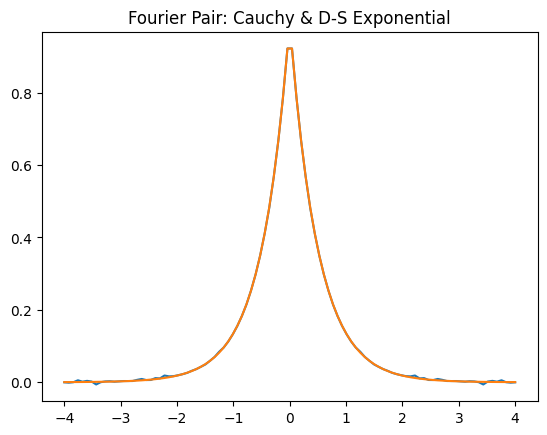

In [73]:
plt.title("Fourier Pair: Cauchy & D-S Exponential")
plt.plot(x, x_InvFT)
plt.plot(x, f(x, lam=2))
plt.show()

## Application to Option Pricing (Unfinished)

In [18]:
# Compute the Black-Scholes-Merton price of European options
# The model for the underlying is geometric Brownian motion

# Contract parameters
T = 1 # maturity
K = 1.1 # strike price

# Market parameters
S0 = 1 # spot price
r = 0.05
q = 0.02

# Model parameter
sigma = 0.4
alpha = -10 # damping factor for a call

In [37]:
import numpy as np
from scipy.integrate import quad

def ghat(xi, a, b, alpha, k, S0):
    exp1 = (np.exp((1 + 1j*xi + alpha)*a) - np.exp((1 + 1j*xi + a)*b))/(1 + 1j*xi + alpha)
    exp2 = (np.exp(k + (1j*xi + alpha)*a) - np.exp(k + (1j*xi + alpha)*b))/(1j*xi + alpha)
    return S0*(exp1 - exp2)

def price(alpha, theta, S0, K, L, U, T, sigma, r):
    k = np.log(K/S0)
    l = np.log(L/S0)
    u = np.log(U/S0)

    dxi = np.pi/3

    if theta == 1:
        a = u
        b = max(k, l)
        def char_func(xi, r, alpha, sigma, T):
            xi = xi + alpha*1j
            return np.exp(1j*-0.05*xi + 1j*alpha - 0.5*(sigma*xi + 1j*alpha)**2*T)
    else:
        a = l
        b = min(k, u)
        def char_func(xi, r, alpha, sigma, T):
            return np.exp(1j*r*(xi + 1j*alpha) - 1j*alpha - 0.5*(sigma*(xi + 1j*alpha) - 1j*alpha)**2*T)

    integrand_real = lambda xi: np.real(ghat(xi, a, b, alpha, k, S0)*np.conjugate(char_func(xi, r, alpha, sigma, T)))
    integrand_comp = lambda xi: np.imag(ghat(xi, a, b, alpha, k, S0)*np.conjugate(char_func(xi, r, alpha, sigma, T)))

    # Perform numerical integration
    real_integral, _ = quad(integrand_real, a, b)
    comp_integral, _ = quad(integrand_comp, a, b)

    return np.exp(-r*T)/(2*np.pi)*(real_integral + 1j*comp_integral)

# Parameters.
S0 = 100  # Example value
K = 110
alpha = 0.1
theta = 1
T = 1
sigma = 0.2
r = 0.05

xwidth = 6
b = xwidth/2
U = S0 * np.exp(b)
L = S0 * np.exp(-b)

# Example call
result = price(alpha, theta, S0, K, L, U, T, sigma, r)
print("Result:", result/xwidth)


Result: (-2.5400695962266697-24.394193955851406j)


## Normal Inverse Gaussian
$$ f(x | a, b) = \frac{aK_1(a\sqrt{a + x^2})}{\pi\sqrt{1+x^2}}\exp(\sqrt{a^2-b^2}+bx)$$


In [185]:
a, b = 1.25, 0.5
def norm_inv(x):
    return norminvgauss.pdf(x, 1.25, 0.5)

def get_f_FT(f, xi):
    f_FT_integrand_real = lambda x: np.real(f(x)*np.exp(1j*xi*x))
    f_FT_integrand_comp = lambda x: np.imag(f(x)*np.exp(1j*xi*x))
    f_FT_real = quad(f_FT_integrand_real, -np.inf, np.inf)[0]
    f_FT_comp = quad(f_FT_integrand_comp, -np.inf, np.inf)[0]
    return f_FT_real + 1j*f_FT_comp

xi = np.linspace(-4, 4, 100)
x_FT = np.vectorize(get_f_FT)(norm_inv, xi)

/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


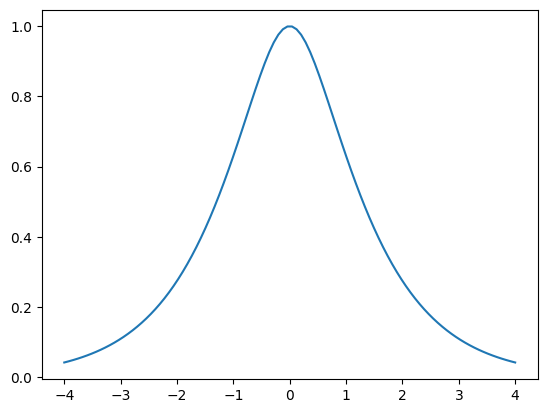

In [134]:
plt.plot(xi, x_FT)
plt.show()

In [124]:
x, xi, a, b = smp.symbols('x, xi, a, b', real=True)
lam = smp.symbols('lambda', real=True, positive=True)
f = (a*besselk(1,a*smp.sqrt(a + x**2)))/(smp.pi*(smp.sqrt(1+x**2)))*smp.exp(smp.sqrt(a**2-b**2)+b*x)


x_FT = _fourier_transform(f, x, xi, 1, 1, "_")
x_FT

KeyboardInterrupt: 

/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


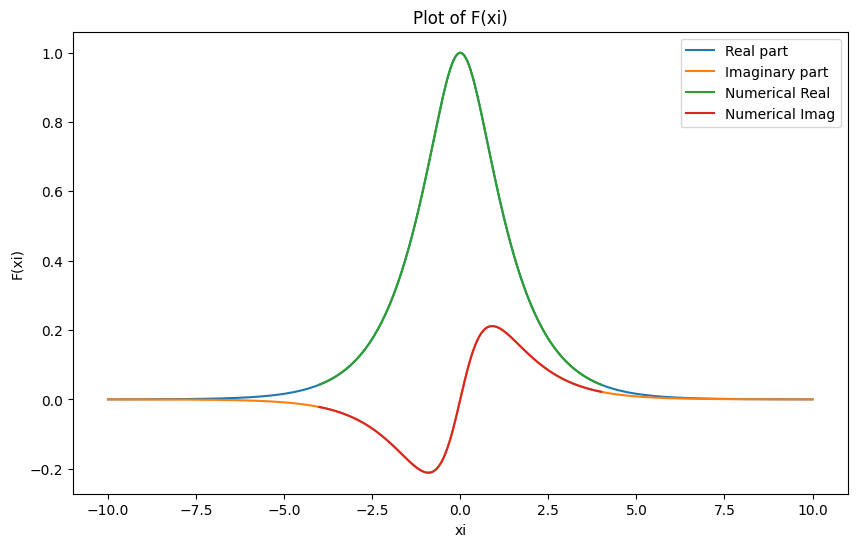

In [188]:
alpha = 1.25
beta = 0.5
delta = 1

# From Guido
def F(xi):
    return np.exp(-delta * (np.sqrt(alpha**2 - (beta + 1j*xi)**2) - np.sqrt(alpha**2 - beta**2)))

# Generate xi values
xi_values = np.linspace(-10, 10, 1000)

# Calculate F for each xi
F_values = F(xi_values)

plt.figure(figsize=(10, 6))
plt.plot(xi_values, np.real(F_values), label='Real part')
plt.plot(xi_values, np.imag(F_values), label='Imaginary part')
plt.plot(xi,x_FT, label="Numerical Real")
plt.plot(xi,np.imag(x_FT), label="Numerical Imag")
plt.xlabel('xi')
plt.ylabel('F(xi)')
plt.title('Plot of F(xi)')
plt.legend()
plt.show()

## Variance-Gamma Process

$$ g(v) = \frac{c^\gamma v^{\gamma-1}e^{-cv}}{\Gamma(\gamma)}$$
$$ f(x) = \int_0^\infty\frac{e^{-x^2/2\sigma^2v}}{\sigma\sqrt{2\pi v}}g(v)dv$$

In [ ]:
a, b = 1.25, 0.5
def var_gamma(x):
    return

def get_f_FT(f, xi):
    f_FT_integrand_real = lambda x: np.real(f(x)*np.exp(1j*xi*x))
    f_FT_integrand_comp = lambda x: np.imag(f(x)*np.exp(1j*xi*x))
    f_FT_real = quad(f_FT_integrand_real, -np.inf, np.inf)[0]
    f_FT_comp = quad(f_FT_integrand_comp, -np.inf, np.inf)[0]
    return f_FT_real + 1j*f_FT_comp

xi = np.linspace(-4, 4, 100)
x_FT = np.vectorize(get_f_FT)(norm_inv, xi)